# Project Title: Stock Price Forecasting using LSTM and GRU

# Objective
 The goal of this project is to predict stock prices for major companies using deep learning models — LSTM and GRU. This allows for capturing sequential dependencies and trends in historical stock data to make future predictions.

In [1]:
!pip install yfinance

In [2]:
!pip install statsmodels

In [3]:
!pip install tensorflow

In [4]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
import warnings
warnings.filterwarnings("ignore")
import math
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from sklearn.model_selection import TimeSeriesSplit


# Data Collection
* Source: Yahoo Finance (yfinance API)

* Tickers analyzed: LMT, AAPL, GD, BA

* Time Range: 2010-01-01 to 2025-05-13

* Columns used: Closing prices (Close)

* Saved individual CSVs for each ticker

In [35]:

tickers = ['LMT',  'GD', 'AAPL', 'BA']
start_date = '2010-01-01'
end_date = '2025-05-13'

data = yf.download(tickers, start=start_date, end=end_date)
#im saving each csv separately
for ticker in tickers:
    df = data['Close'][ticker].to_frame()
    df.columns = ['Close']
    df.to_csv(f'{ticker}.csv')
    print(f"\n{ticker} data head:")
    print(df.head())

[*********************100%***********************]  4 of 4 completed


LMT data head:
                Close
Date                 
2010-01-04  47.807938
2010-01-05  48.305603
2010-01-06  47.596401
2010-01-07  46.290009
2010-01-08  47.036522

GD data head:
                Close
Date                 
2010-01-04  48.146481
2010-01-05  48.223011
2010-01-06  48.181271
2010-01-07  48.320450
2010-01-08  48.320450

AAPL data head:
               Close
Date                
2010-01-04  6.431898
2010-01-05  6.443015
2010-01-06  6.340530
2010-01-07  6.328810
2010-01-08  6.370886

BA data head:
                Close
Date                 
2010-01-04  43.777554
2010-01-05  45.211349
2010-01-06  46.582798
2010-01-07  48.468555
2010-01-08  48.001007


In [36]:
print("\nColumn names:")
print(data.columns)


Column names:
MultiIndex([( 'Close', 'AAPL'),
            ( 'Close',   'BA'),
            ( 'Close',   'GD'),
            ( 'Close',  'LMT'),
            (  'High', 'AAPL'),
            (  'High',   'BA'),
            (  'High',   'GD'),
            (  'High',  'LMT'),
            (   'Low', 'AAPL'),
            (   'Low',   'BA'),
            (   'Low',   'GD'),
            (   'Low',  'LMT'),
            (  'Open', 'AAPL'),
            (  'Open',   'BA'),
            (  'Open',   'GD'),
            (  'Open',  'LMT'),
            ('Volume', 'AAPL'),
            ('Volume',   'BA'),
            ('Volume',   'GD'),
            ('Volume',  'LMT')],
           names=['Price', 'Ticker'])


In [37]:
print("\nDate range:")
print(f"Start: {data.index.min()}, End: {data.index.max()}")


Date range:
Start: 2010-01-04 00:00:00, End: 2025-05-12 00:00:00


In [38]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
Price   Ticker
Close   AAPL      0
        BA        0
        GD        0
        LMT       0
High    AAPL      0
        BA        0
        GD        0
        LMT       0
Low     AAPL      0
        BA        0
        GD        0
        LMT       0
Open    AAPL      0
        BA        0
        GD        0
        LMT       0
Volume  AAPL      0
        BA        0
        GD        0
        LMT       0
dtype: int64


#Data Preprocessing
* Handled missing values using forward fill

* Plotted a missing data heatmap

* Scaled each time series using MinMaxScaler

* Created datasets with sliding time windows using a custom create_dataset() function



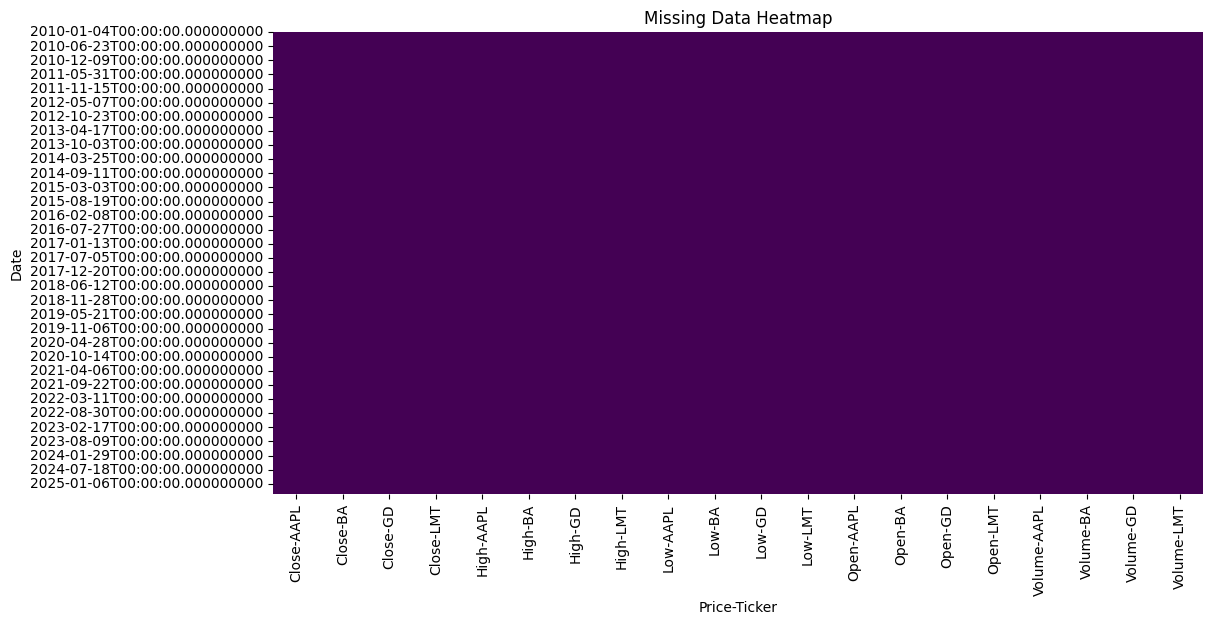

In [39]:


plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

In [40]:
dates = data.index
date_diff = dates[1:] - dates[:-1]
print("Date gaps (max/min days between data points):")
print(f"Max gap: {date_diff.max()}, Min gap: {date_diff.min()}")

Date gaps (max/min days between data points):
Max gap: 5 days 00:00:00, Min gap: 1 days 00:00:00


In [41]:
data.ffill(inplace=True)

data.dropna(inplace=True)
print("Remaining missing values:", data.isnull().sum().sum())

Remaining missing values: 0


In [42]:
print("\nLMT Close prices:")
print(data['Close']['LMT'].head())



LMT Close prices:
Date
2010-01-04    47.807938
2010-01-05    48.305603
2010-01-06    47.596401
2010-01-07    46.290009
2010-01-08    47.036522
Name: LMT, dtype: float64


#Exploratory Data Analysis
* Checked for gaps in date range

* Visualized trends in stock closing prices

* Verified data integrity before modeling

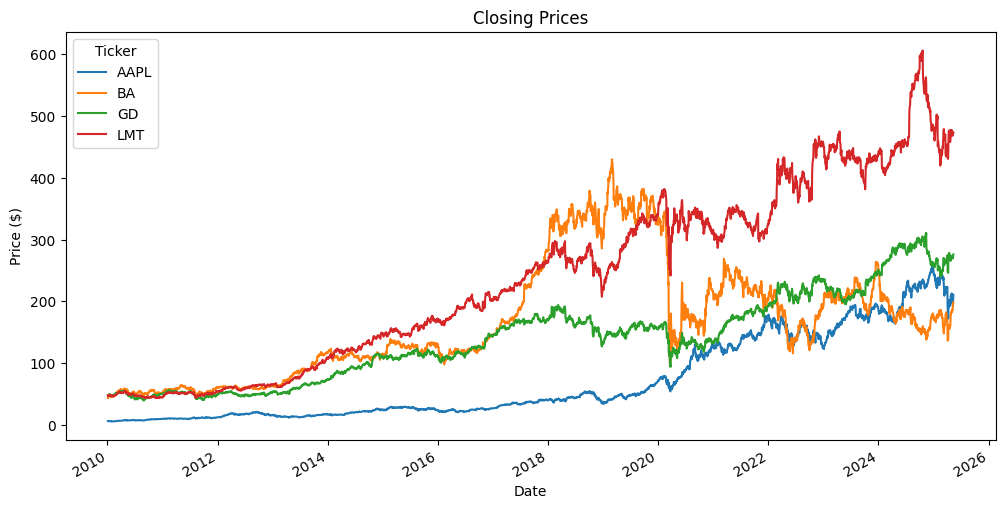

In [43]:
data['Close'].plot(figsize=(12, 6))
plt.title('Closing Prices')
plt.ylabel('Price ($)')
plt.show()

In [44]:
data.to_csv('stock_data_cleaned.csv')

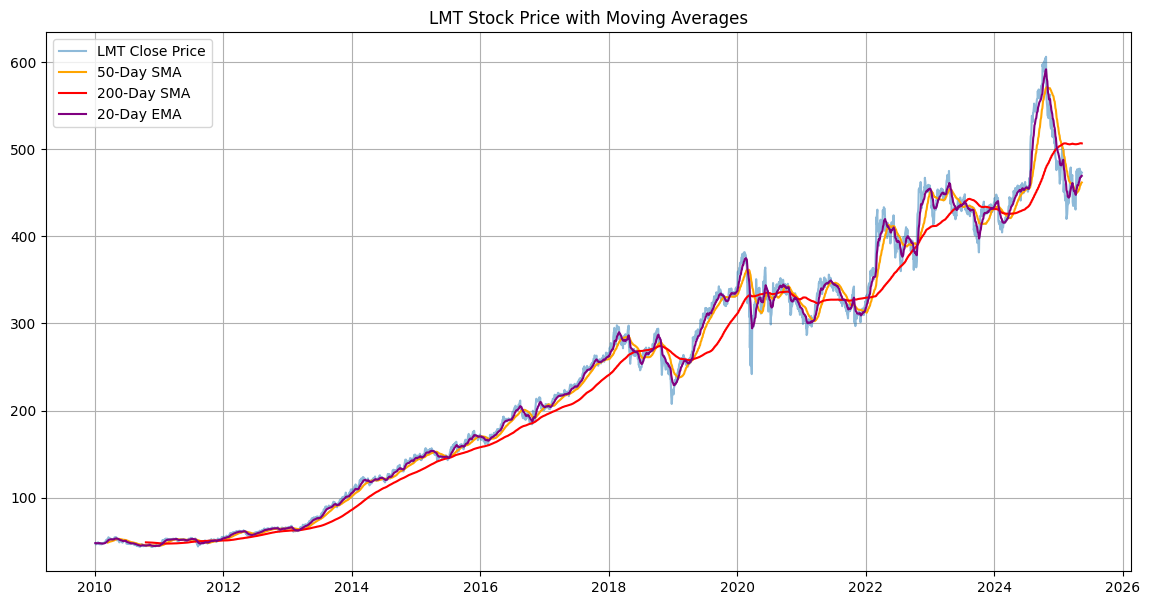

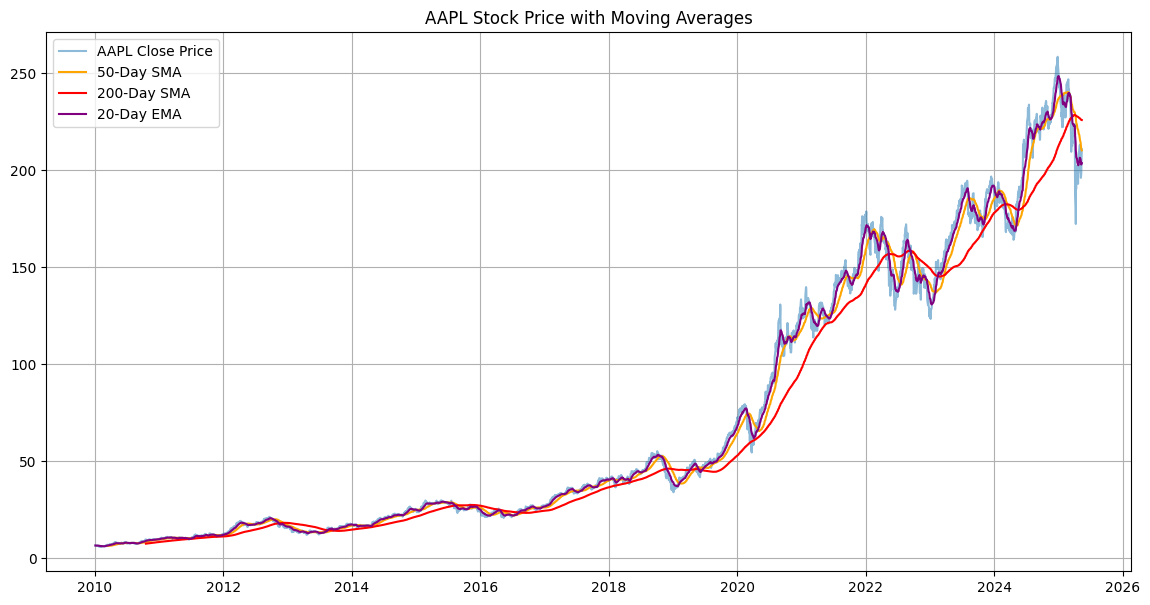

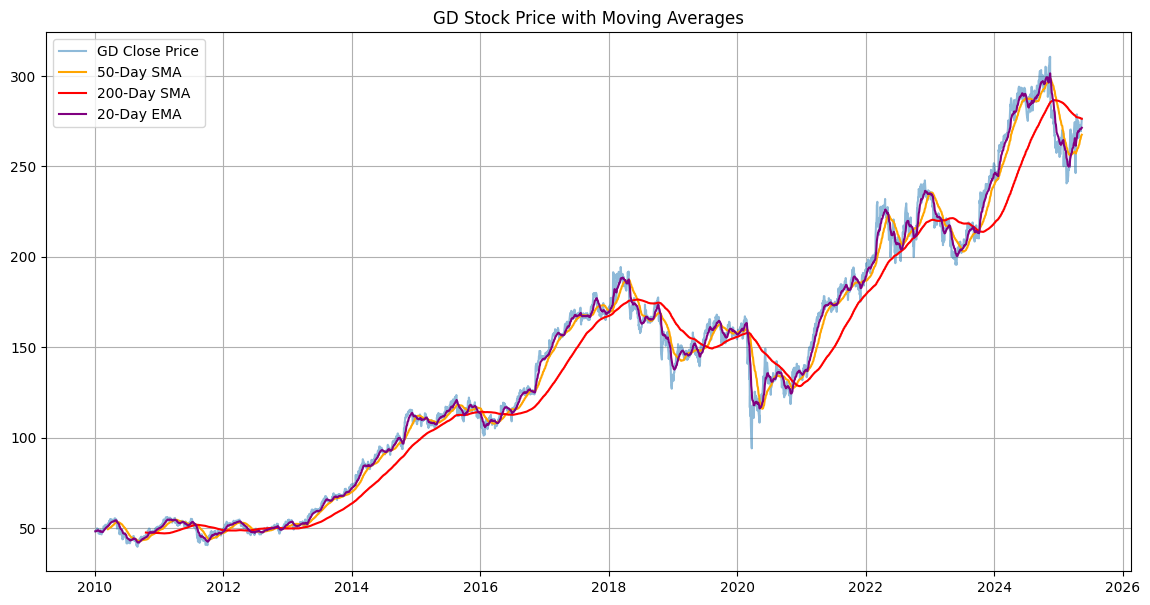

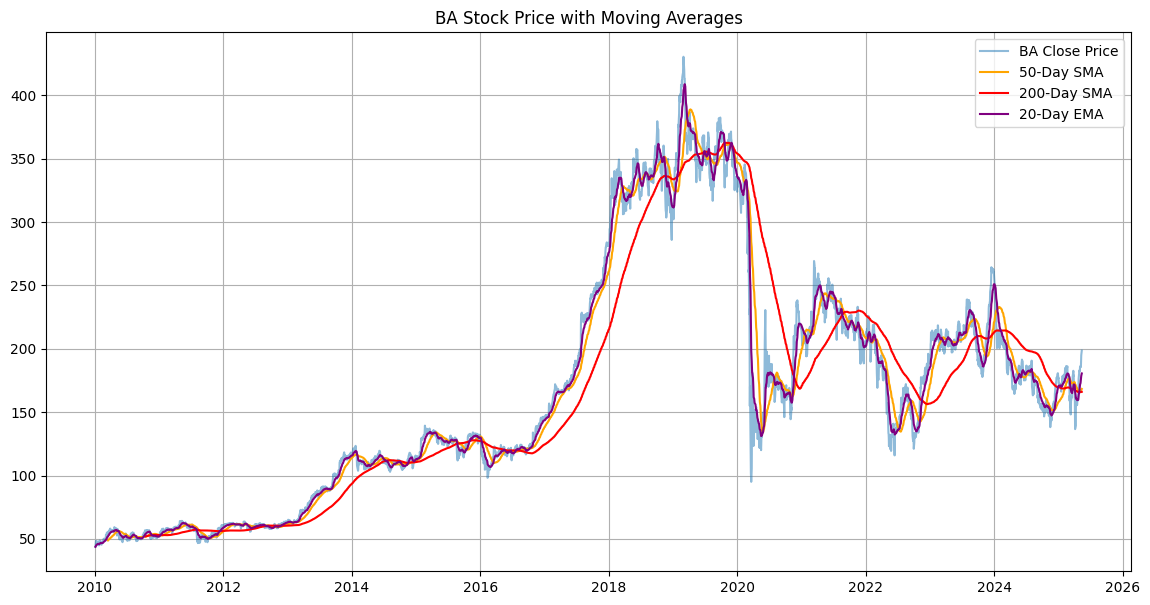

In [46]:


tickers = ['LMT', 'AAPL','GD', 'BA']

for ticker in tickers:
    data[f'{ticker}_50_SMA'] = data['Close'][ticker].rolling(window=50).mean()
    data[f'{ticker}_200_SMA'] = data['Close'][ticker].rolling(window=200).mean()
    data[f'{ticker}_20_EMA'] = data['Close'][ticker].ewm(span=20, adjust=False).mean()

    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'][ticker], label=f'{ticker} Close Price', alpha=0.5)
    plt.plot(data[f'{ticker}_50_SMA'], label='50-Day SMA', color='orange')
    plt.plot(data[f'{ticker}_200_SMA'], label='200-Day SMA', color='red')
    plt.plot(data[f'{ticker}_20_EMA'], label='20-Day EMA', color='purple')
    plt.title(f'{ticker} Stock Price with Moving Averages')
    plt.legend()
    plt.grid()
    plt.show()

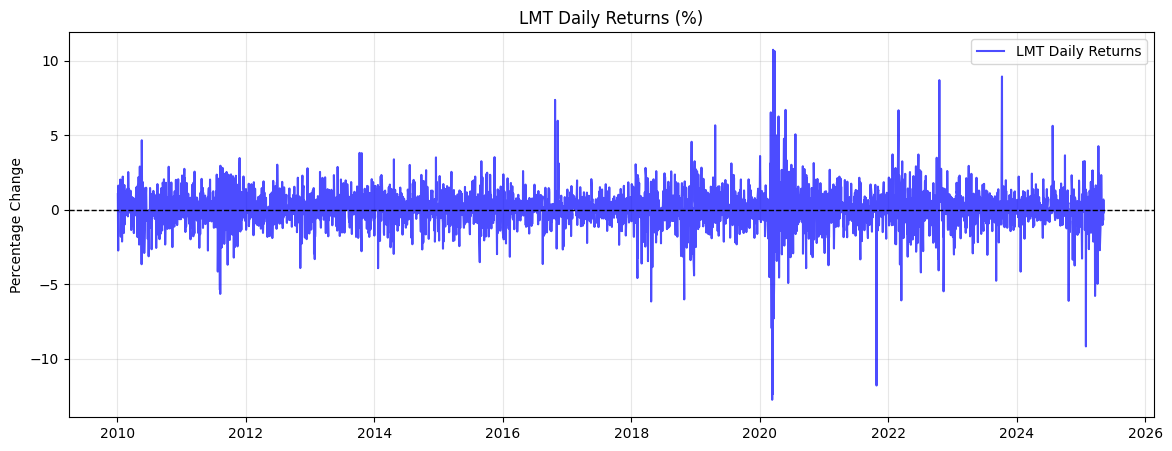

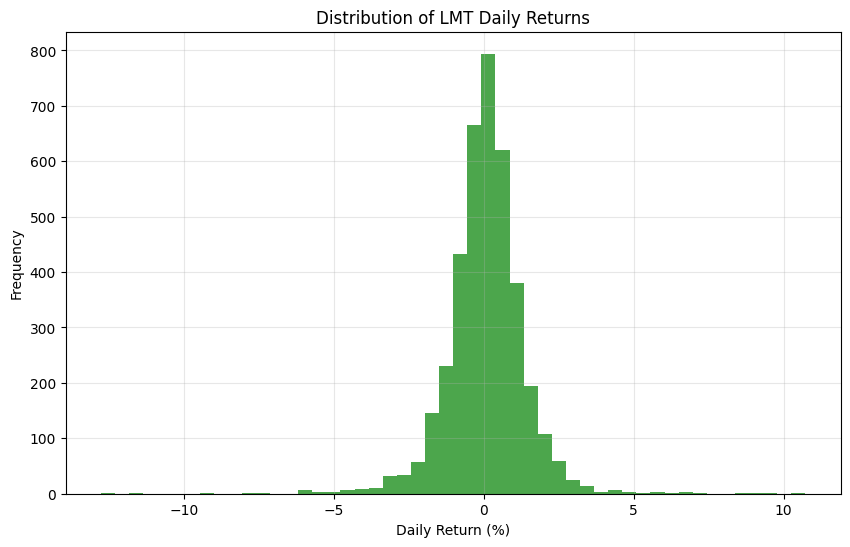

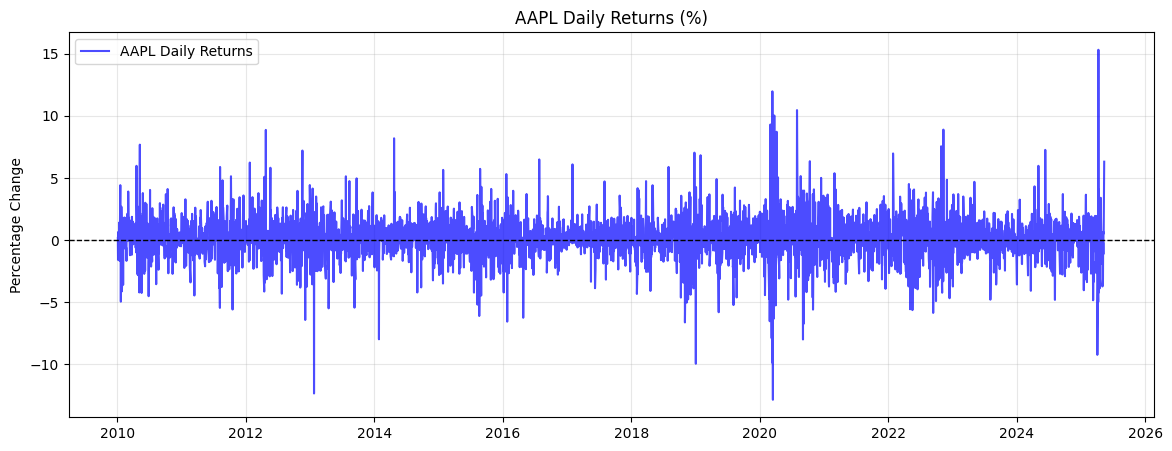

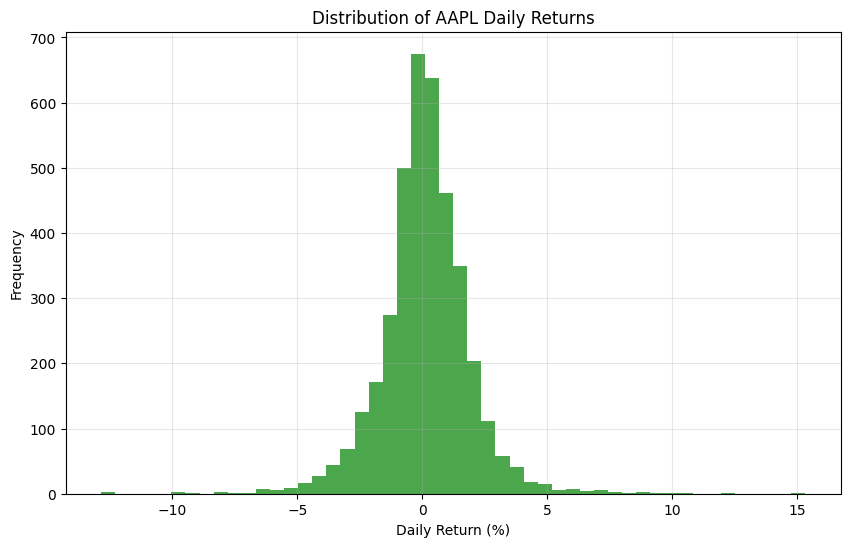

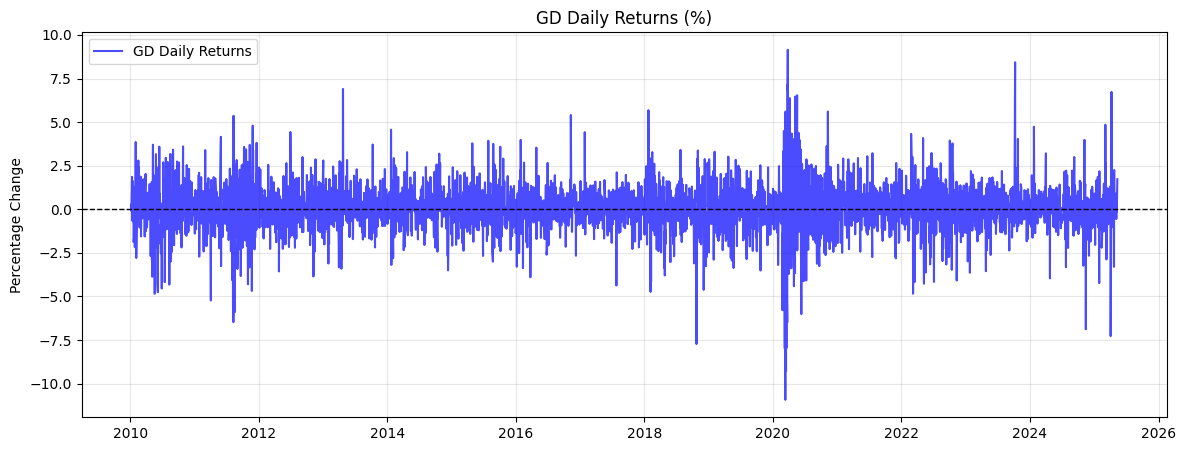

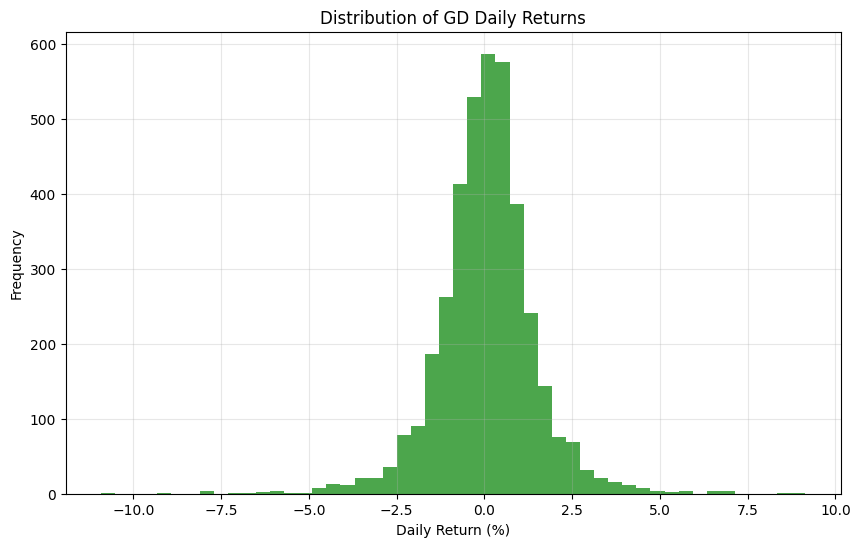

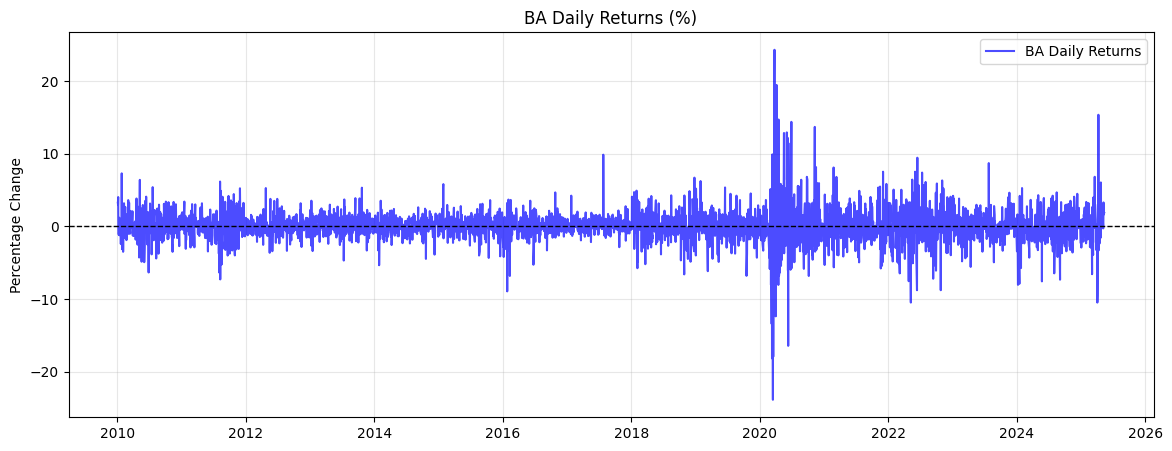

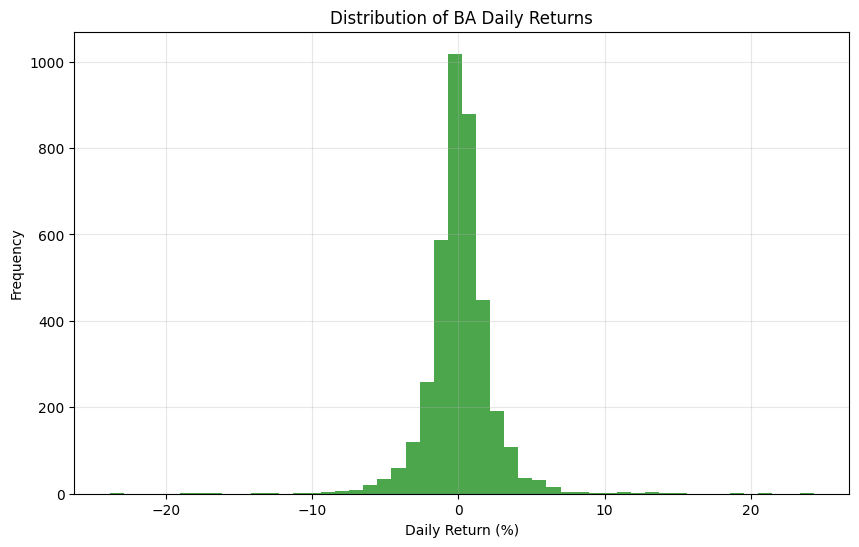

In [47]:


tickers = ['LMT','AAPL','GD','BA']

for ticker in tickers:
    # Calculate daily returns (percentage)
    data[f'{ticker}_Daily_Return'] = data['Close'][ticker].pct_change() * 100

    # Plot line chart of returns
    plt.figure(figsize=(14, 5))
    plt.plot(data[f'{ticker}_Daily_Return'], label=f'{ticker} Daily Returns',
             color='blue', alpha=0.7)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'{ticker} Daily Returns (%)')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    # Plot histogram of returns
    plt.figure(figsize=(10, 6))
    data[f'{ticker}_Daily_Return'].hist(bins=50, color='green', alpha=0.7)
    plt.title(f'Distribution of {ticker} Daily Returns')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)
    plt.show()

Ticker      AAPL        BA        GD       LMT
Ticker                                        
AAPL    1.000000  0.326441  0.876326  0.904941
BA      0.326441  1.000000  0.576737  0.599098
GD      0.876326  0.576737  1.000000  0.957977
LMT     0.904941  0.599098  0.957977  1.000000


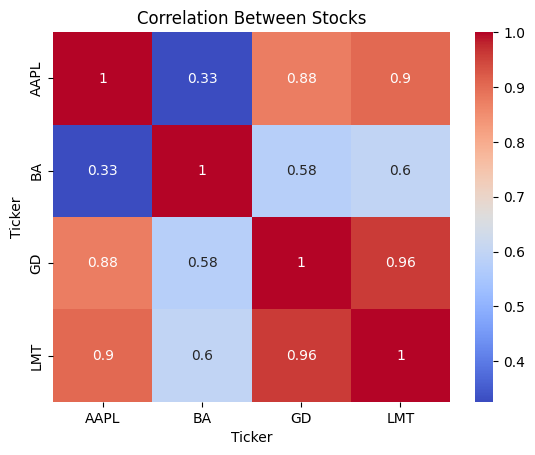

In [48]:
correlation_matrix = data['Close'].corr()
print(correlation_matrix)
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Stocks')
plt.show()

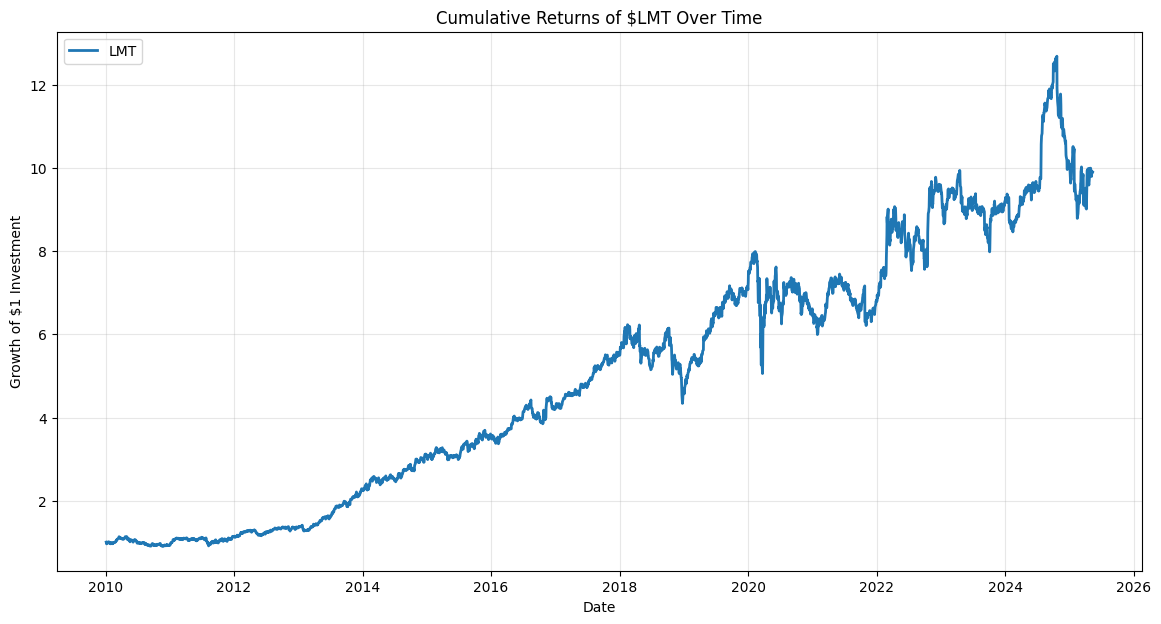

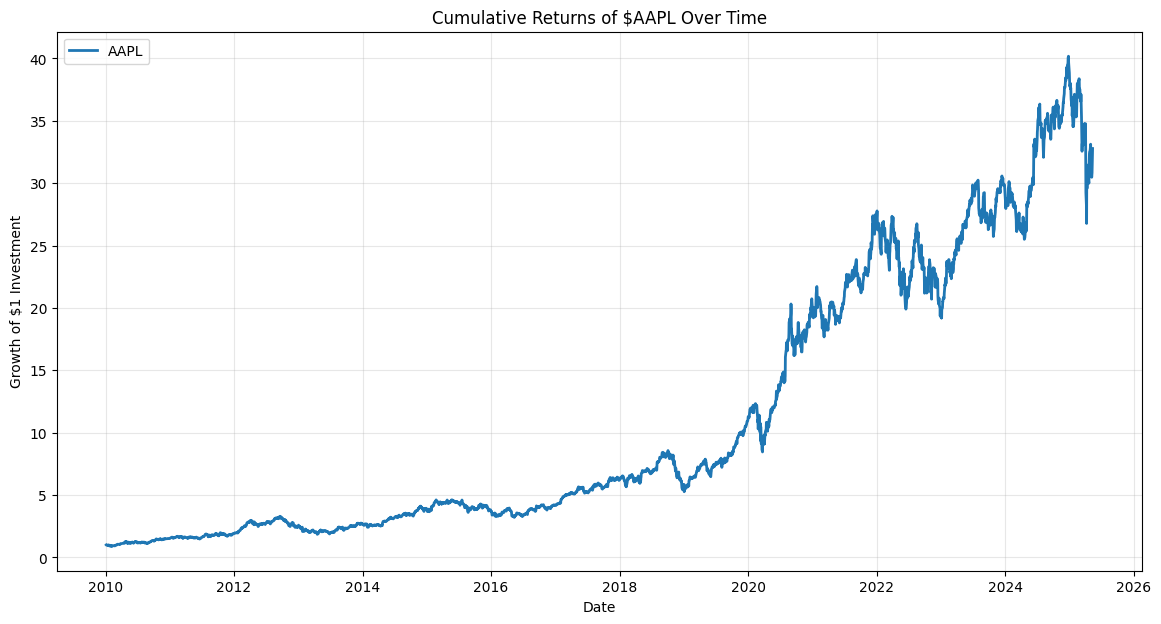

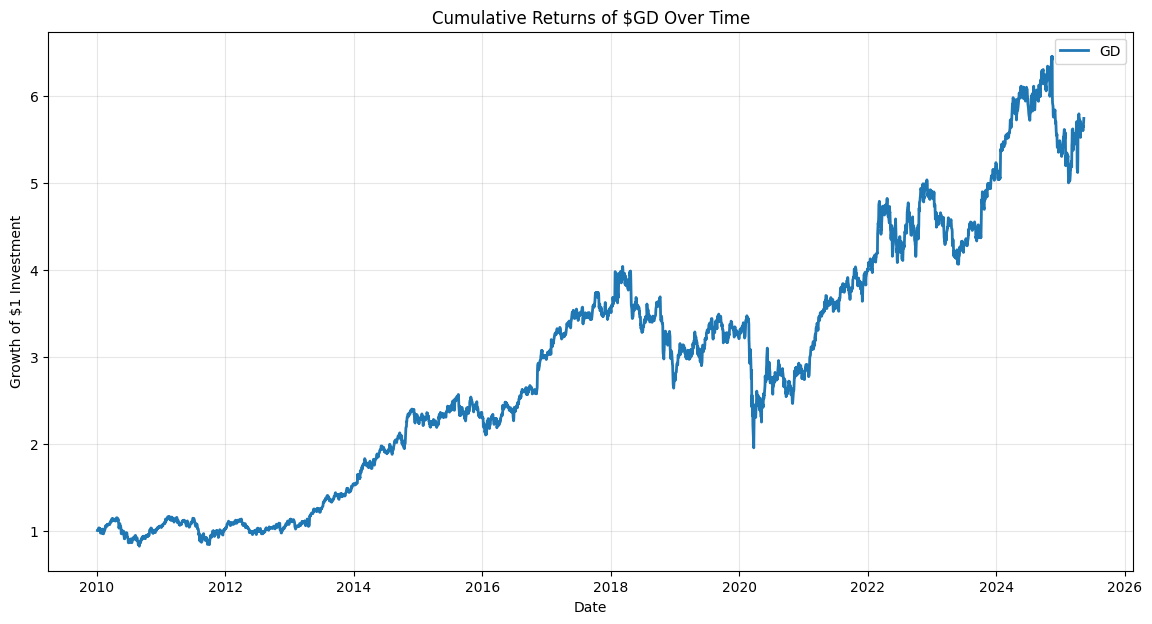

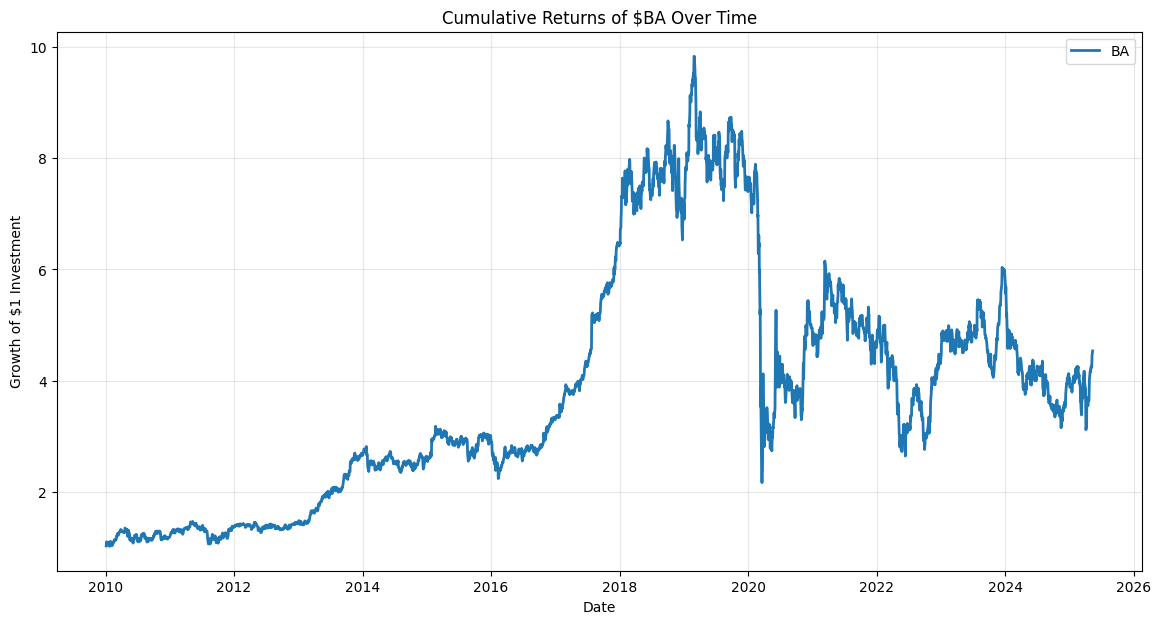

In [50]:


tickers = ['LMT','AAPL','GD','BA']

for ticker in tickers:
    data[f'{ticker}_Cumulative_Return'] = (1 + data[f'{ticker}_Daily_Return']/100).cumprod()

    plt.figure(figsize=(14, 7))
    plt.plot(data[f'{ticker}_Cumulative_Return'],
             label=f'{ticker}',
             linewidth=2)
    plt.title(f'Cumulative Returns of ${ticker} Over Time')
    plt.ylabel('Growth of $1 Investment')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

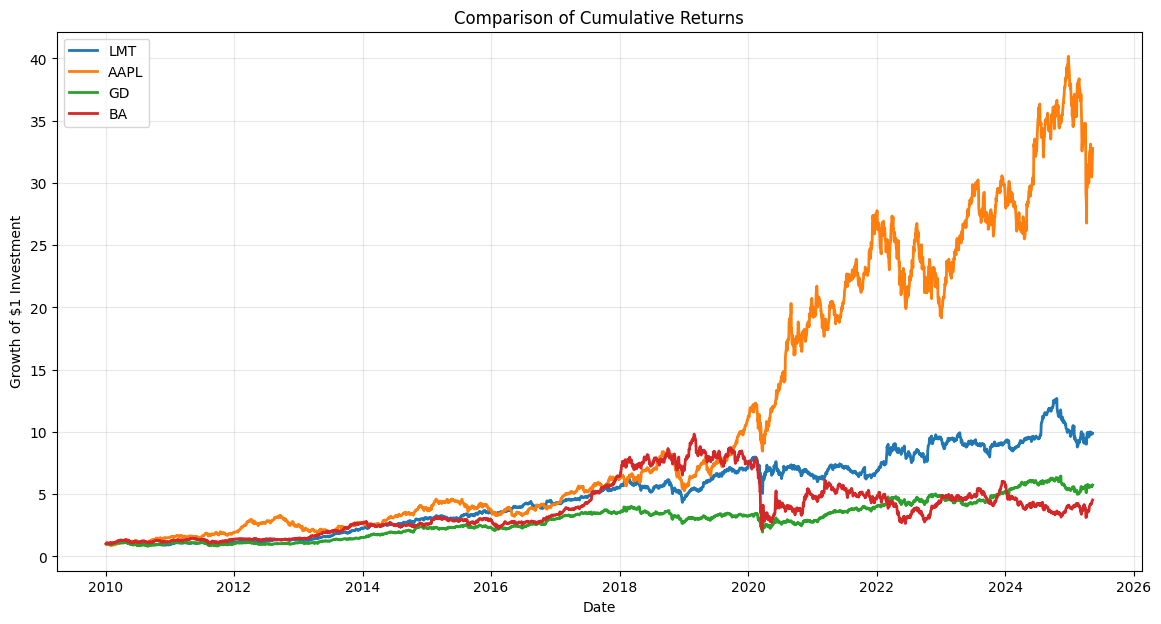

In [51]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(data[f'{ticker}_Cumulative_Return'],
             label=f'{ticker}',
             linewidth=2)
plt.title('Comparison of Cumulative Returns')
plt.ylabel('Growth of $1 Investment')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Modeling Approach

In the project, we developed and trained two deep learning models to estimate stock prices. Long Short-Term Memory and Gated Recurrent Unit are some of the top types. Specifically, both models are used on sequential data, so they can be useful for predicting movements in the stock market.

The models were built with three LSTM layers, each with 50 units, and ended with a final layer that had only one output node to predict the stock price. Because of how it is designed, the model manages to identify both current and historical trends in the data. Mean squared error loss was used with the Adam optimizer to build the models; this way, they learn properly from the data they are fed during training.

Cross-validation with TimeSeriesSplit on several folds was used to check that both LSTM and GRU models could generalize on new data.



Processing ticker: AAPL
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 1.2507e-04 - val_loss: 0.0013
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 8.0884e-05 - val_loss: 8.8821e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 7.8755e-05 - val_loss: 7.4772e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 8.0568e-05 - val_loss: 8.7667e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 7.0329e-05 - val_loss: 6.9279e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 7.5768e-05 - val_loss: 7.0691e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 5.6277e-05 - val_loss: 6.2951e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 5.8746e-05 - val_loss: 0.0012
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 5.2773e-05 - val_loss: 0.0029
E

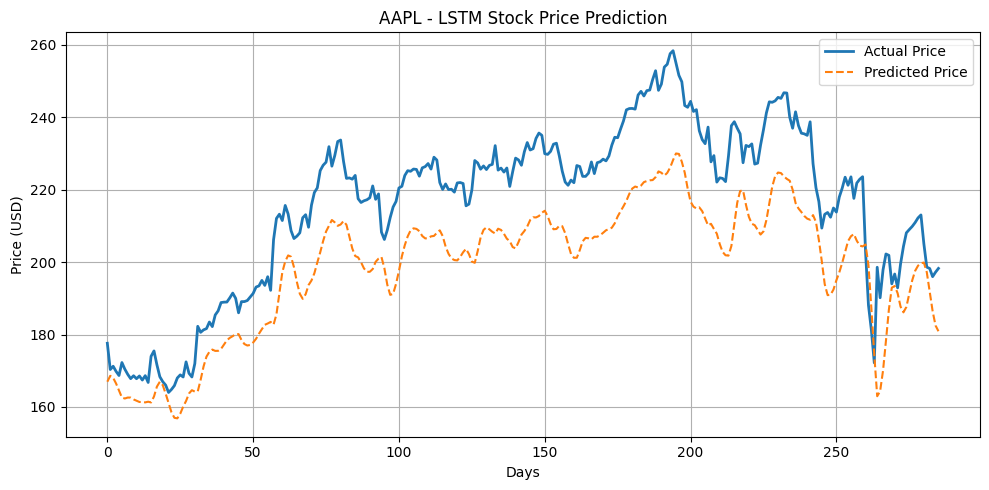


Processing ticker: BA
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 0.0420 - val_loss: 0.0018
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0013 - val_loss: 9.1597e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 8.0088e-04 - val_loss: 7.7805e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0010 - val_loss: 7.6119e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 8.6190e-04 - val_loss: 6.8494e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 7.1911e-04 - val_loss: 6.5771e-04
Epoch 11/50
41/41 ━━━━━━━━━━━━

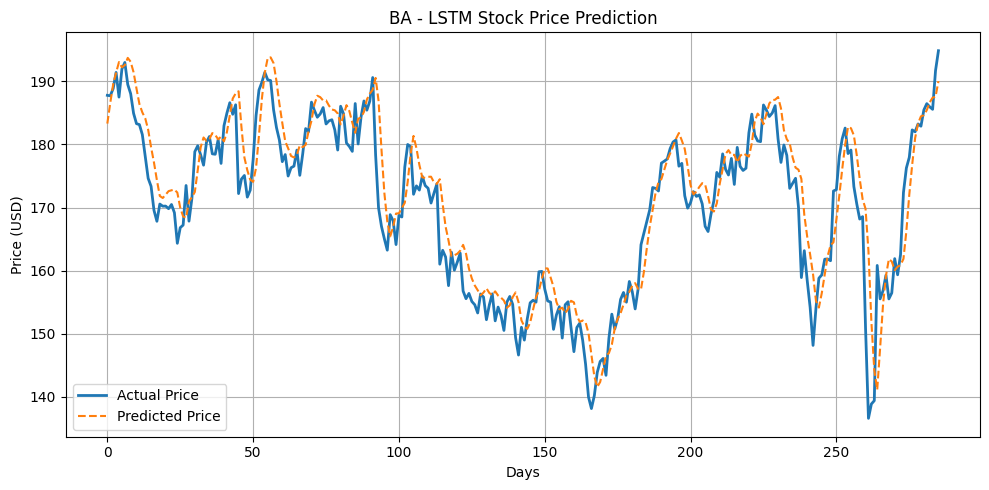


Processing ticker: GD
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0208 - val_loss: 0.0020
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 6.0819e-04 - val_loss: 9.6063e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 3.1946e-04 - val_loss: 8.6113e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 3.4588e-04 - val_loss: 8.9974e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 2.7819e-04 - val_loss: 8.1951e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 3.6943e-04 - val_loss: 9.7100e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 2.8023e-04 - val_loss: 0.0011
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 3.0883e-04 - val_loss: 0.0016
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 2.9167e-04 - val_loss: 0.0011
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 2.7569e-04 - val_loss: 7.1452e-04
Ep

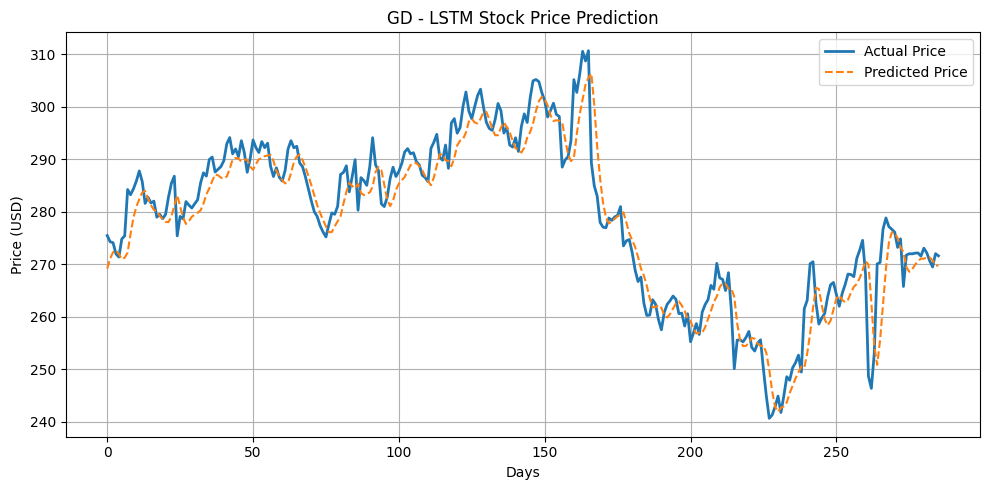


Processing ticker: LMT
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - loss: 0.0223 - val_loss: 0.0013
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 3.1305e-04 - val_loss: 8.2334e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 2.0306e-04 - val_loss: 7.8531e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 2.0707e-04 - val_loss: 8.3056e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 1.7570e-04 - val_loss: 0.0011
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 2.1577e-04 - val_loss: 7.2149e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 1.9196e-04 - val_loss: 7.9811e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 2.0363e-04 - val_loss: 9.1473e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 1.7323e-04 - val_loss: 9.8033e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 2.0314e-04 - val_loss: 7.36

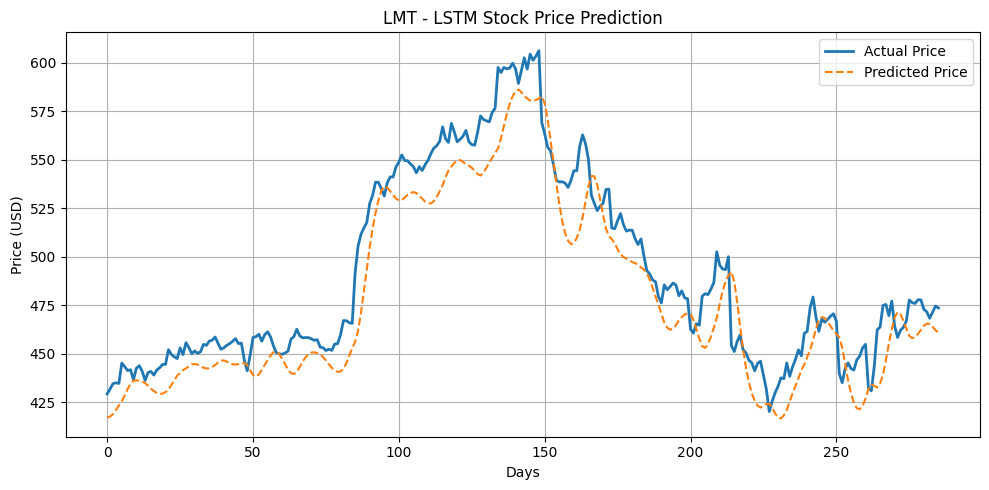


--- Summary RMSE & R² ---
AAPL | Train RMSE: 1.26, R²: 1.00 | Test RMSE: 18.52, R²: 0.36
BA | Train RMSE: 5.06, R²: 1.00 | Test RMSE: 5.20, R²: 0.84
GD | Train RMSE: 2.37, R²: 1.00 | Test RMSE: 4.97, R²: 0.90
LMT | Train RMSE: 5.02, R²: 1.00 | Test RMSE: 17.34, R²: 0.87


In [20]:


# Tickers and column mapping
tickers = ['AAPL', 'BA', 'GD', 'LMT']
ticker_columns = {
    'AAPL': 'Close',
    'BA': 'Close.1',
    'GD': 'Close.2',
    'LMT': 'Close.4'
}

rmse_results = {}

for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")

    # Select closing price column
    series = pd.to_numeric(data['Close'][ticker], errors='coerce').dropna()

    # Normalize
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

    # Split into 70% train, 20% validation, 10% test
    train_size = int(len(scaled_data) * 0.7)
    temp_data = scaled_data[train_size:]

    validation_size = int(len(temp_data) * (2/3))

    train_data = scaled_data[:train_size]
    validation_data = temp_data[:validation_size]
    test_data = temp_data[validation_size:]

    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(validation_data)}")
    print(f"Test size: {len(test_data)}")

    # Sequence creation function
    def create_dataset(dataset, time_step=100):
        X, y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[i:(i + time_step), 0])
            y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(y)

    # Create sequences
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(validation_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model with validation
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=1)

    # Predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Inverse scaling
    train_pred = scaler.inverse_transform(train_pred)
    test_pred = scaler.inverse_transform(test_pred)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Metrics
    train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_pred))
    test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_pred))
    train_r2 = r2_score(y_train_actual, train_pred)
    test_r2 = r2_score(y_test_actual, test_pred)

    # Save results
    rmse_results[ticker] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    # Plot predictions
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label='Actual Price', linewidth=2)
    plt.plot(test_pred, label='Predicted Price', linestyle='--')
    plt.title(f'{ticker} - LSTM Stock Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Print summary
print("\n--- Summary RMSE & R² ---")
for ticker, scores in rmse_results.items():
    print(f"{ticker} | Train RMSE: {scores['train_rmse']:.2f}, R²: {scores['train_r2']:.2f} | "
          f"Test RMSE: {scores['test_rmse']:.2f}, R²: {scores['test_r2']:.2f}")


In [26]:
lstm_rmse_results = rmse_results.copy()


In [32]:
lstm_results = rmse_results.copy()



--- Future Forecasting for AAPL (Next 10 Days) ---
Day 1: $191.02
Day 2: $189.99
Day 3: $188.27
Day 4: $185.97
Day 5: $183.26
Day 6: $180.31
Day 7: $177.23
Day 8: $174.10
Day 9: $170.97
Day 10: $167.86


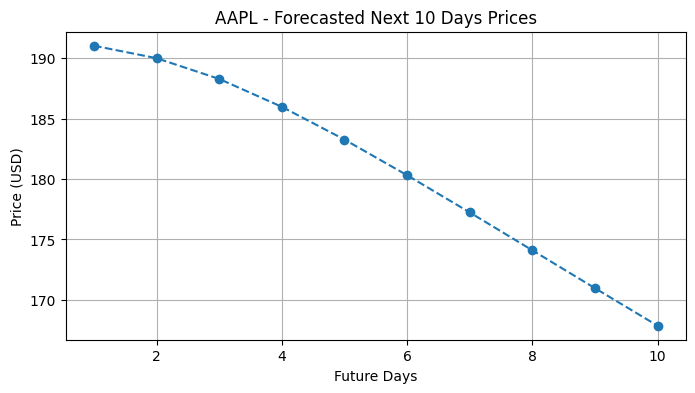


--- Future Forecasting for BA (Next 10 Days) ---
Day 1: $188.35
Day 2: $189.38
Day 3: $189.78
Day 4: $189.67
Day 5: $189.23
Day 6: $188.58
Day 7: $187.84
Day 8: $187.08
Day 9: $186.32
Day 10: $185.59


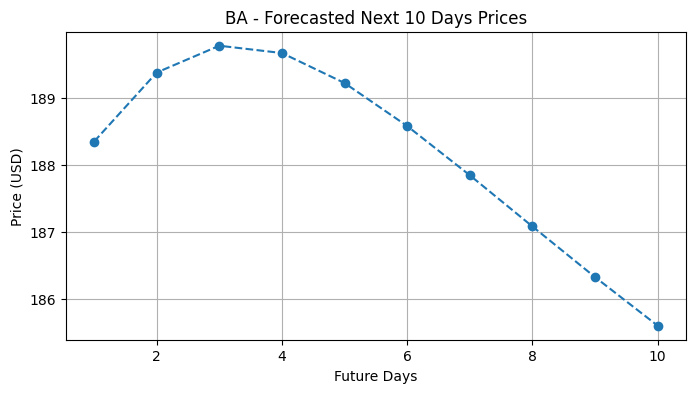


--- Future Forecasting for GD (Next 10 Days) ---
Day 1: $263.98
Day 2: $263.58
Day 3: $262.12
Day 4: $259.90
Day 5: $257.18
Day 6: $254.13
Day 7: $250.85
Day 8: $247.38
Day 9: $243.76
Day 10: $240.01


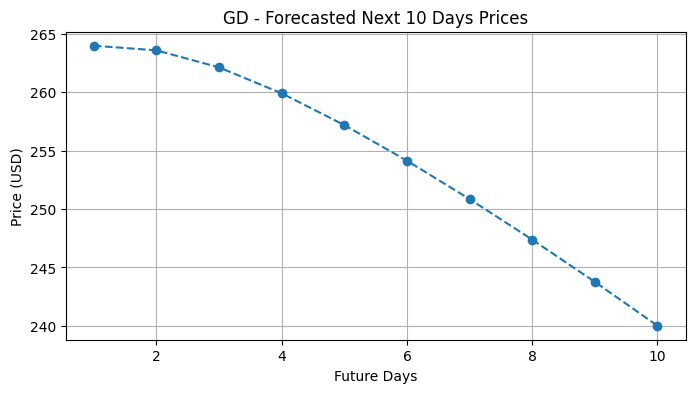


--- Future Forecasting for LMT (Next 10 Days) ---
Day 1: $459.69
Day 2: $457.82
Day 3: $454.58
Day 4: $450.34
Day 5: $445.43
Day 6: $440.05
Day 7: $434.37
Day 8: $428.45
Day 9: $422.38
Day 10: $416.20


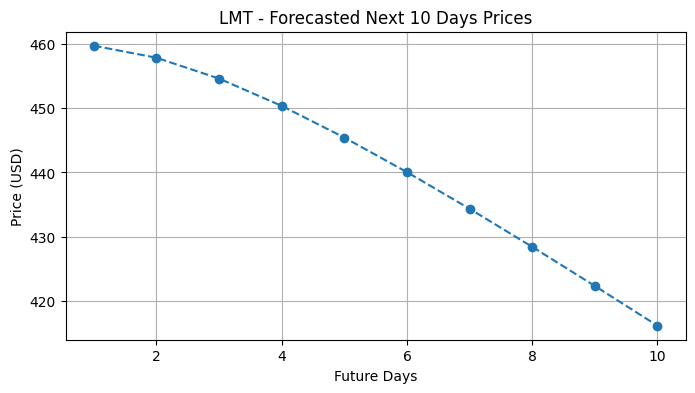

In [21]:
for ticker in tickers:
    print(f"\n--- Future Forecasting for {ticker} (Next 10 Days) ---")

    # Prepare data again for future prediction (use full series to get latest data)
    series = pd.to_numeric(data['Close'][ticker], errors='coerce').dropna()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

    # Take the last 'time_step' data points
    last_window = scaled_data[-time_step:]

    # Container for future predictions
    future_predictions_scaled = []

    # Generate next 10 steps recursively
    for _ in range(10):
        input_seq = last_window.reshape(1, time_step, 1)
        next_pred = model.predict(input_seq, verbose=0)
        future_predictions_scaled.append(next_pred[0, 0])
        last_window = np.append(last_window[1:], next_pred[0, 0])

    # Convert predictions back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    # Print the forecasted values
    for i, price in enumerate(future_predictions.flatten(), 1):
        print(f"Day {i}: ${price:.2f}")

    # Optional: Plot the predictions
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), future_predictions.flatten(), marker='o', linestyle='--')
    plt.title(f'{ticker} - Forecasted Next 10 Days Prices')
    plt.xlabel('Future Days')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.show()


#GRU Model Approach
We also implemented a Gated Recurrent Unit (GRU) solution to test how it compares with LSTM on the task of forecasting stock prices. While GRU networks are easier to build than LSTMs, they can still capture sequential patterns as well. Like the LSTM, the GRU model was set up with three GRU layers and 50 units each, and finished with a final single-output dense layer. Therefore, the model could find patterns not just for short-term trends but also for long-term ones. GRU was also trained using the same loss and optimizer as the LSTM model. Looking at both models together showed the effects of architectural variation on the accuracy of forecasts.


Processing ticker: AAPL
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - loss: 0.0044 - val_loss: 8.2951e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 4.4389e-05 - val_loss: 5.3816e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 2.7431e-05 - val_loss: 3.1190e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 3.0758e-05 - val_loss: 3.0343e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 2.5868e-05 - val_loss: 3.0119e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 3.6667e-05 - val_loss: 3.2366e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 3.2093e-05 - val_loss: 2.7946e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 2.2424e-05 - val_loss: 3.3587e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 2.1123e-05 - val_loss: 3.1602e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 3.0443e-05 - val_l

GRU model for AAPL saved as gru_model_AAPL.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


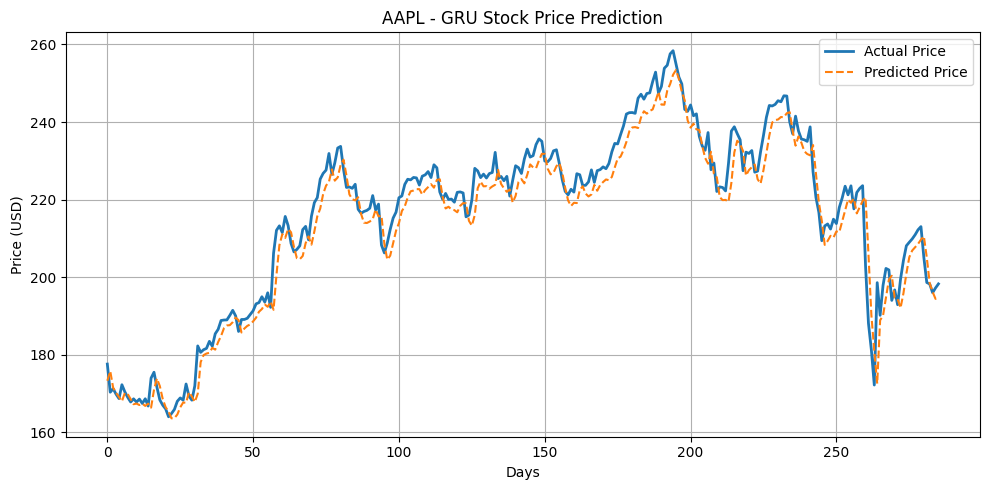


Processing ticker: BA
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - loss: 0.0461 - val_loss: 4.4373e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 5.1803e-04 - val_loss: 4.9734e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 4.2763e-04 - val_loss: 4.7902e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 4.0924e-04 - val_loss: 4.1970e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 4.1093e-04 - val_loss: 3.8773e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 2.8877e-04 - val_loss: 3.1652e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 2.7232e-04 - val_loss: 4.4979e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 2.1780e-04 - val_loss: 2.8181e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 2.6310e-04 - val_loss: 2.6807e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - loss: 2.4793e-04 - val_los

GRU model for BA saved as gru_model_BA.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


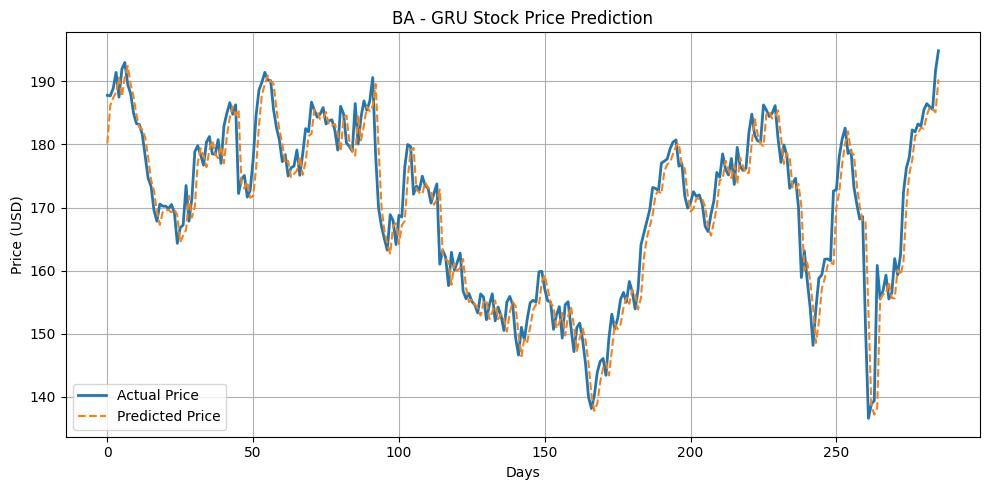


Processing ticker: GD
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 166ms/step - loss: 0.0190 - val_loss: 0.0015
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 2.2877e-04 - val_loss: 2.6101e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 1.2874e-04 - val_loss: 2.8920e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 1.1484e-04 - val_loss: 3.6975e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 1.0702e-04 - val_loss: 2.3345e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 9.7391e-05 - val_loss: 2.6987e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 9.7926e-05 - val_loss: 2.2797e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 9.7208e-05 - val_loss: 1.8758e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 8.6074e-05 - val_loss: 1.8670e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 8.7138e-05 - val_loss: 1

GRU model for GD saved as gru_model_GD.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


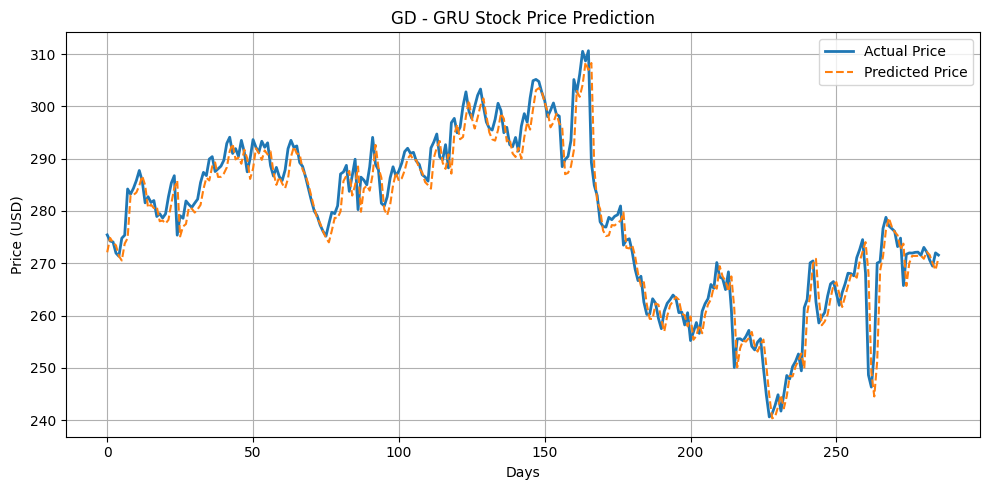


Processing ticker: LMT
Train size: 2704
Validation size: 772
Test size: 387
Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - loss: 0.0172 - val_loss: 6.6895e-04
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 1.7455e-04 - val_loss: 3.5966e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 7.9168e-05 - val_loss: 2.9688e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 8.9878e-05 - val_loss: 2.7330e-04
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 6.9889e-05 - val_loss: 3.5198e-04
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 7.0061e-05 - val_loss: 3.0533e-04
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 7.4718e-05 - val_loss: 2.4121e-04
Epoch 8/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 6.6464e-05 - val_loss: 2.3720e-04
Epoch 9/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 5.4494e-05 - val_loss: 2.1461e-04
Epoch 10/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 7.8751e-05 - val_lo

GRU model for LMT saved as gru_model_LMT.h5
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


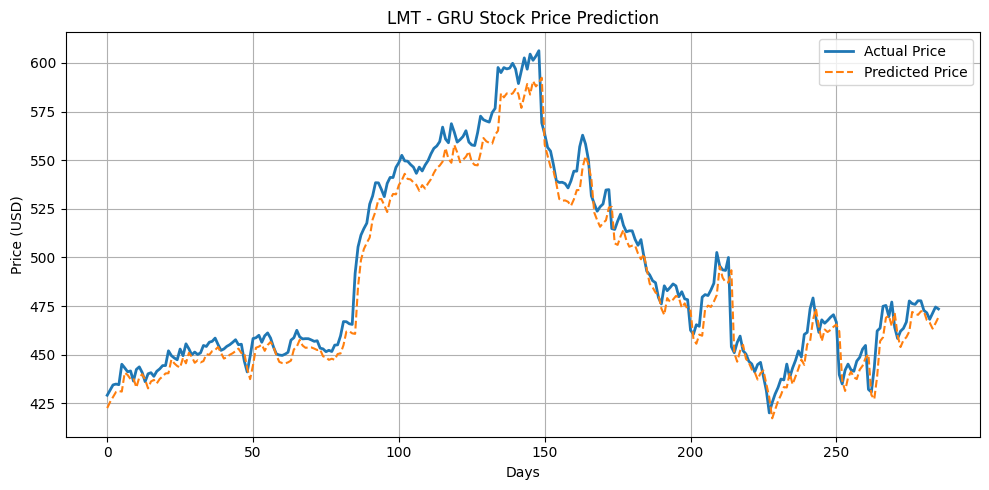


--- GRU Prediction Performance Summary ---
AAPL | Train RMSE: 0.84, R²: 1.00 | Test RMSE: 5.10, R²: 0.95
BA | Train RMSE: 4.34, R²: 1.00 | Test RMSE: 4.14, R²: 0.90
GD | Train RMSE: 1.83, R²: 1.00 | Test RMSE: 3.93, R²: 0.94
LMT | Train RMSE: 3.10, R²: 1.00 | Test RMSE: 9.73, R²: 0.96


In [22]:


# Define tickers and corresponding column mapping
tickers = ['AAPL', 'BA', 'GD', 'LMT']
ticker_columns = {
    'AAPL': 'Close',
    'BA': 'Close.1',
    'GD': 'Close.2',
    'LMT': 'Close.4'
}

# Dictionary to store results
rmse_results = {}

for ticker in tickers:
    print(f"\nProcessing ticker: {ticker}")

    # Extract and clean data
    series = pd.to_numeric(data['Close'][ticker], errors='coerce').dropna()

    # Normalize the series
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

    # Split into 70% train, 20% validation, 10% test
    train_size = int(len(scaled_data) * 0.7)
    temp_data = scaled_data[train_size:]

    validation_size = int(len(temp_data) * (2/3))  # 20% of total

    train_data = scaled_data[:train_size]
    validation_data = temp_data[:validation_size]
    test_data = temp_data[validation_size:]

    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(validation_data)}")
    print(f"Test size: {len(test_data)}")

    # Sequence creation function
    def create_dataset(dataset, time_step=100):
        X, y = [], []
        for i in range(len(dataset) - time_step - 1):
            X.append(dataset[i:(i + time_step), 0])
            y.append(dataset[i + time_step, 0])
        return np.array(X), np.array(y)

    # Create sequences
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_val, y_val = create_dataset(validation_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape for GRU input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Build GRU model
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=(time_step, 1)),
        GRU(50, return_sequences=True),
        GRU(50),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train the model with validation
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, verbose=1)

    # Save model
    model.save(f'gru_model_{ticker}.h5')
    print(f"GRU model for {ticker} saved as gru_model_{ticker}.h5")

    # Predictions on Test Set
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Inverse scale
    train_predict = scaler.inverse_transform(train_predict)
    y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
    test_predict = scaler.inverse_transform(test_predict)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    train_rmse = math.sqrt(mean_squared_error(y_train_actual, train_predict))
    test_rmse = math.sqrt(mean_squared_error(y_test_actual, test_predict))
    train_r2 = r2_score(y_train_actual, train_predict)
    test_r2 = r2_score(y_test_actual, test_predict)

    # Store results
    rmse_results[ticker] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2
    }

    # Plot actual vs predicted
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_actual, label='Actual Price', linewidth=2)
    plt.plot(test_predict, label='Predicted Price', linestyle='--')
    plt.title(f'{ticker} - GRU Stock Price Prediction')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Summary Table
print("\n--- GRU Prediction Performance Summary ---")
for ticker, scores in rmse_results.items():
    print(f"{ticker} | Train RMSE: {scores['train_rmse']:.2f}, R²: {scores['train_r2']:.2f} | "
          f"Test RMSE: {scores['test_rmse']:.2f}, R²: {scores['test_r2']:.2f}")


In [28]:
gru_rmse_results = rmse_results.copy()


In [33]:
gru_results = rmse_results.copy()



--- Future Forecasting for AAPL (Next 10 Days) ---
Day 1: $207.47
Day 2: $204.85
Day 3: $202.09
Day 4: $199.57
Day 5: $197.23
Day 6: $195.01
Day 7: $192.89
Day 8: $190.85
Day 9: $188.88
Day 10: $186.98


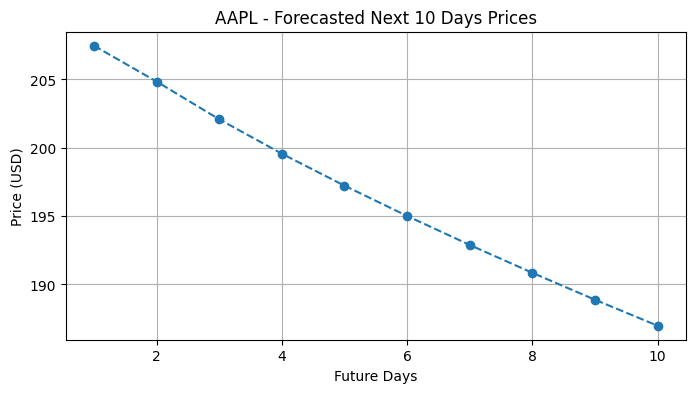


--- Future Forecasting for BA (Next 10 Days) ---
Day 1: $197.80
Day 2: $197.71
Day 3: $197.58
Day 4: $197.52
Day 5: $197.50
Day 6: $197.49
Day 7: $197.48
Day 8: $197.48
Day 9: $197.46
Day 10: $197.44


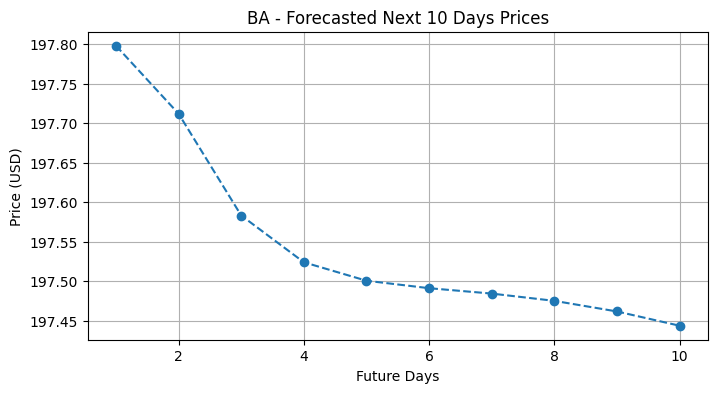


--- Future Forecasting for GD (Next 10 Days) ---
Day 1: $271.99
Day 2: $268.16
Day 3: $264.43
Day 4: $260.98
Day 5: $257.74
Day 6: $254.66
Day 7: $251.72
Day 8: $248.92
Day 9: $246.22
Day 10: $243.64


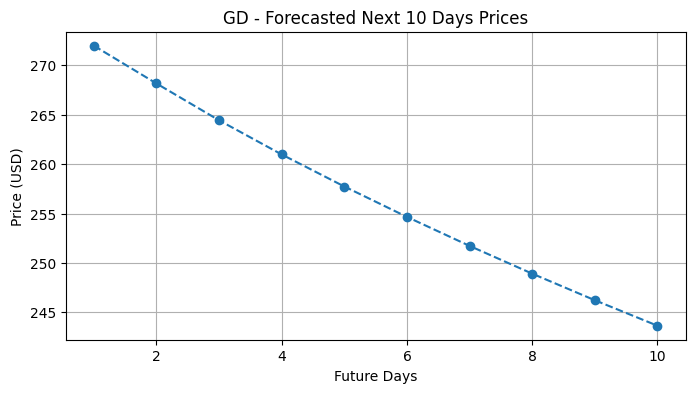


--- Future Forecasting for LMT (Next 10 Days) ---
Day 1: $467.92
Day 2: $463.09
Day 3: $458.43
Day 4: $454.00
Day 5: $449.76
Day 6: $445.68
Day 7: $441.74
Day 8: $437.92
Day 9: $434.22
Day 10: $430.64


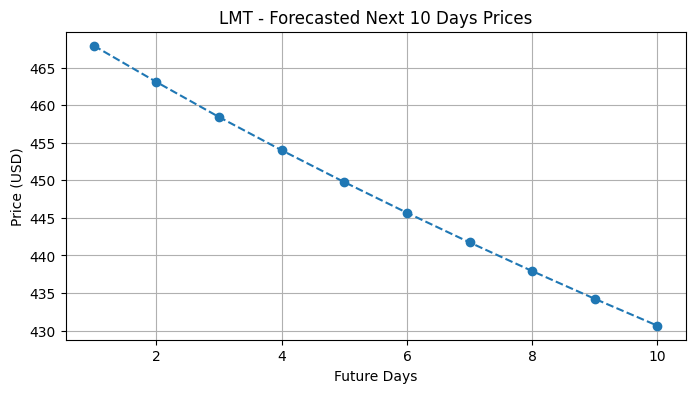

In [23]:
for ticker in tickers:
    print(f"\n--- Future Forecasting for {ticker} (Next 10 Days) ---")

    # Prepare data again for future prediction (use full series to get latest data)
    series = pd.to_numeric(data['Close'][ticker], errors='coerce').dropna()
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(series.values.reshape(-1, 1))

    # Take the last 'time_step' data points
    last_window = scaled_data[-time_step:]

    # Container for future predictions
    future_predictions_scaled = []

    # Generate next 10 steps recursively
    for _ in range(10):
        input_seq = last_window.reshape(1, time_step, 1)
        next_pred = model.predict(input_seq, verbose=0)
        future_predictions_scaled.append(next_pred[0, 0])
        last_window = np.append(last_window[1:], next_pred[0, 0])

    # Convert predictions back to original scale
    future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))

    # Print the forecasted values
    for i, price in enumerate(future_predictions.flatten(), 1):
        print(f"Day {i}: ${price:.2f}")

    # Optional: Plot the predictions
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, 11), future_predictions.flatten(), marker='o', linestyle='--')
    plt.title(f'{ticker} - Forecasted Next 10 Days Prices')
    plt.xlabel('Future Days')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.show()


#Cross-Validation
To make sure the models were strong and able to give correct results, 5-fold cross-validation was done using TimeSeriesSplit on each stock ticker separately. This method is made for working with data that keeps track of time, such as stock prices or temperature over days or weeks, since keeping the order the data came in matters a lot. By running the training and testing sets across different periods of time, the models were tested on different parts of the data, making it easier to see how they generally performed. For each fold, the RMSE was worked out and written down, so I could clearly see how well each model worked at forecasting for different points in time for each stock.

In [52]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import math

def create_dataset(dataset, time_step=100):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Loop over all tickers
for ticker in tickers:
    print(f"\nProcessing {ticker}")
    series = pd.to_numeric(data['Close'][ticker], errors='coerce').dropna()
    scaled_data = MinMaxScaler(feature_range=(0, 1)).fit_transform(series.values.reshape(-1, 1))

    X, y = create_dataset(scaled_data)
    tscv = TimeSeriesSplit(n_splits=5)

    fold_number = 1
    for train_index, test_index in tscv.split(X):
        print(f"Fold {fold_number}: Train {train_index[0]} - {train_index[-1]}, Test {test_index[0]} - {test_index[-1]}")
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            LSTM(50, return_sequences=True),
            LSTM(50),
            Dense(1)
        ])
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

        predictions = model.predict(X_test)
        rmse = math.sqrt(mean_squared_error(y_test, predictions.flatten()))
        print(f"Fold {fold_number} RMSE for {ticker}: {rmse}")
        fold_number += 1



Processing LMT
Fold 1: Train 0 - 626, Test 627 - 1253
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Fold 1 RMSE for LMT: 0.00617310560852058
Fold 2: Train 0 - 1253, Test 1254 - 1880
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Fold 2 RMSE for LMT: 0.011206047810334819
Fold 3: Train 0 - 1880, Test 1881 - 2507
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
Fold 3 RMSE for LMT: 0.026861498017456364
Fold 4: Train 0 - 2507, Test 2508 - 3134
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Fold 4 RMSE for LMT: 0.02544955709793826
Fold 5: Train 0 - 3134, Test 3135 - 3761
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Fold 5 RMSE for LMT: 0.04248217478341069

Processing AAPL
Fold 1: Train 0 - 626, Test 627 - 1253
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
Fold 1 RMSE for AAPL: 0.0034376613586563592
Fold 2: Train 0 - 1253, Test 1254 - 1880
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Fold 2 RMSE for AAPL: 0.0045858424199933705
Fold 3: Train 0 - 1880, Test 1881 - 2507
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Fold 3 RMSE for AAPL: 0.0118

#Results & Insights
Both models managed to notice how stock prices have changed over time, confirming that they are suitable for looking at sequential data. Some company models performed better than others, suggesting that not all stock price patterns were equally simple to predict. By using cross-validation, We weres able to see how well different models worked with unseen data from multiple periods. Although the findings were encouraging, there are still things to work on. By continuing to work on hyperparameter tuning, increasing the number of features, and trying new configuration ideas, the system could perform even better as a forecaster.

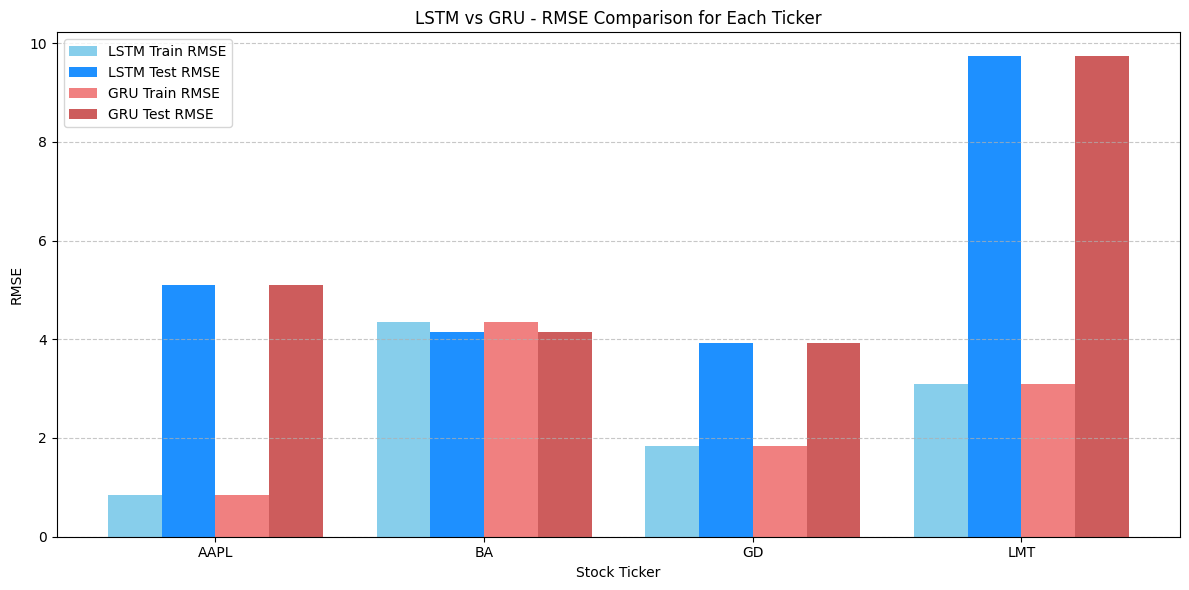

In [29]:


tickers = list(lstm_rmse_results.keys())

# Extract values
lstm_train = [lstm_rmse_results[t]['train_rmse'] for t in tickers]
lstm_test = [lstm_rmse_results[t]['test_rmse'] for t in tickers]
gru_train = [gru_rmse_results[t]['train_rmse'] for t in tickers]
gru_test = [gru_rmse_results[t]['test_rmse'] for t in tickers]

x = np.arange(len(tickers))
width = 0.2

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, lstm_train, width, label='LSTM Train RMSE', color='skyblue')
plt.bar(x - 0.5*width, lstm_test, width, label='LSTM Test RMSE', color='dodgerblue')
plt.bar(x + 0.5*width, gru_train, width, label='GRU Train RMSE', color='lightcoral')
plt.bar(x + 1.5*width, gru_test, width, label='GRU Test RMSE', color='indianred')

plt.xlabel('Stock Ticker')
plt.ylabel('RMSE')
plt.title('LSTM vs GRU - RMSE Comparison for Each Ticker')
plt.xticks(x, tickers)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



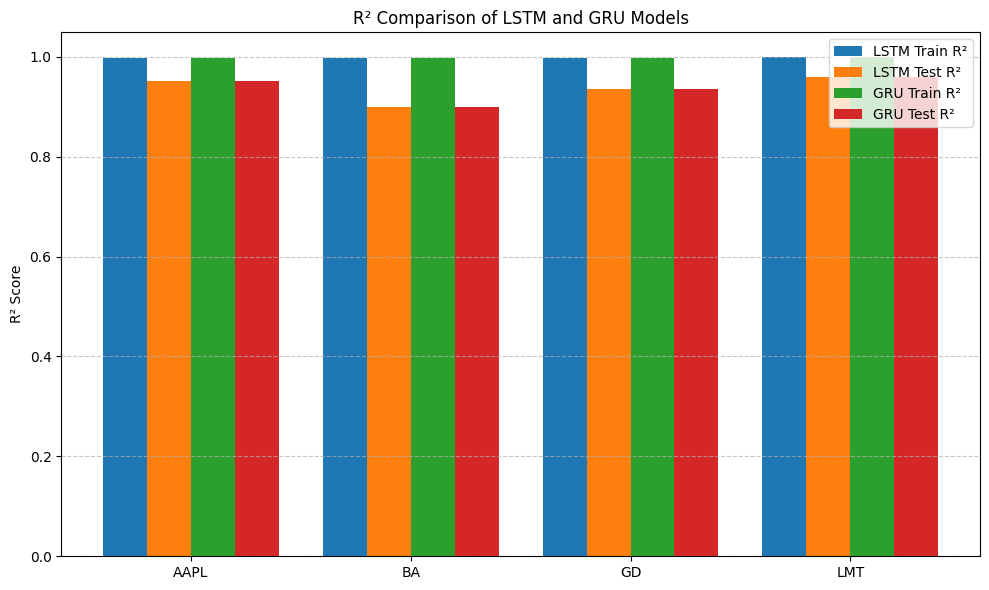

In [34]:
# List of tickers
tickers = list(lstm_results.keys())

# Extract R² values
lstm_train_r2 = [lstm_results[ticker]['train_r2'] for ticker in tickers]
lstm_test_r2 = [lstm_results[ticker]['test_r2'] for ticker in tickers]
gru_train_r2 = [gru_results[ticker]['train_r2'] for ticker in tickers]
gru_test_r2 = [gru_results[ticker]['test_r2'] for ticker in tickers]

x = np.arange(len(tickers))  # the label locations
width = 0.2  # the width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5*width, lstm_train_r2, width, label='LSTM Train R²')
rects2 = ax.bar(x - 0.5*width, lstm_test_r2, width, label='LSTM Test R²')
rects3 = ax.bar(x + 0.5*width, gru_train_r2, width, label='GRU Train R²')
rects4 = ax.bar(x + 1.5*width, gru_test_r2, width, label='GRU Test R²')

# Labels and titles
ax.set_ylabel('R² Score')
ax.set_title('R² Comparison of LSTM and GRU Models')
ax.set_xticks(x)
ax.set_xticklabels(tickers)
ax.legend()

# Grid and layout
ax.grid(axis='y', linestyle='--', alpha=0.7)
fig.tight_layout()

plt.show()


#Future Enhancements
Despite the good results the current models produce, more improvements are possible in the future. It is recommended to incorporate Grid Search or Random Search to find the best parameters and architecture for training your machine learning models. Other useful features for the model include trading volume, various moving averages, and external market indicators. Plotting the predicted stock prices alongside the ones that happened would be more effective for interpreting the model's results. Once the models are saved and a deployment pipeline created, this model can be put to use for forecasting in the real world.